<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#label-dictionary" data-toc-modified-id="label-dictionary-1">label dictionary</a></span></li><li><span><a href="#make-tfrecord" data-toc-modified-id="make-tfrecord-2">make tfrecord</a></span></li><li><span><a href="#decode-check" data-toc-modified-id="decode-check-3">decode check</a></span></li></ul></div>

In [1]:
import os
import glob
import json
import random
from tqdm.notebook import tqdm
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
base_dir = os.getenv("HOME") + "/UDIGO"

In [3]:
folder_list = glob.glob(base_dir + "/dataset/train/*")
num_classes = len(folder_list)
num_classes

55

# label dictionary

In [4]:
save_dir = os.path.join(base_dir, "data")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [5]:
label_df = pd.read_csv(save_dir + "/category.csv")
label_df.head()

,id,category,sentence
0,1,공원,"피크닉이 가고 싶어지는 공원이네요!,공원 산책하며 한 템포 쉬어가는 건 어떨까요?"
1,2,공항,"여행 가고 싶어지는 공항이군요!,가장 설레는 곳 공항입니다!"
2,3,놀이공원,"신나는 놀이공원이군요!,꿈과 환상의 나라 놀이공원입니다."
3,4,다리,어느 다리를 찾으시나요?
4,5,미술관,멋진 그림이 가득한 미술관이군요!


In [6]:
label_id = label_df.to_dict('index')
label_id

{0: {'id': 1,
  'category': '공원',
  'sentence': '피크닉이 가고 싶어지는 공원이네요!,공원 산책하며 한 템포 쉬어가는 건 어떨까요?'},
 1: {'id': 2,
  'category': '공항',
  'sentence': '여행 가고 싶어지는 공항이군요!,가장 설레는 곳 공항입니다!'},
 2: {'id': 3,
  'category': '놀이공원',
  'sentence': '신나는 놀이공원이군요!,꿈과 환상의 나라 놀이공원입니다.'},
 3: {'id': 4, 'category': '다리', 'sentence': '어느 다리를 찾으시나요?'},
 4: {'id': 5, 'category': '미술관', 'sentence': '멋진 그림이 가득한 미술관이군요!'},
 5: {'id': 6,
  'category': '볼링장',
  'sentence': '볼링장이에요~ 스트라이크 기원합니닷!!,여럿이서 즐기기에  볼링장이 최고죠'},
 6: {'id': 7, 'category': '산', 'sentence': '산이에요~~ 정상까지 고고!!,산에서 여유를 느껴보세요.'},
 7: {'id': 8, 'category': '아이스링크', 'sentence': '스케이트 타러 아이스링크 가보실까요?'},
 8: {'id': 9, 'category': '아쿠아리움', 'sentence': '예쁜 물고기가 있는 아쿠아리움이군요!'},
 9: {'id': 10,
  'category': '호텔',
  'sentence': '아늑한 호텔에서 편히 쉬어보아요!,멀리 가지 말고 호텔에서 호캉스 어떨까요?'},
 10: {'id': 11, 'category': '궁궐', 'sentence': '옛 정취를 느낄 수 있는 궁궐이군요!'},
 11: {'id': 12, 'category': '지하철역', 'sentence': '지하철역이네요~ 어디로 가보실까요?'},
 12: {'id': 13,
  'category': '놀이터',
  'sen

In [7]:
label_dict = {}
for i in range(len(label_id)):
    label_dict[label_id[i]['id']] = label_id[i]['category']

In [8]:
label_dict

{1: '공원',
 2: '공항',
 3: '놀이공원',
 4: '다리',
 5: '미술관',
 6: '볼링장',
 7: '산',
 8: '아이스링크',
 9: '아쿠아리움',
 10: '호텔',
 11: '궁궐',
 12: '지하철역',
 13: '놀이터',
 14: '수영장',
 15: '폭포',
 16: '동물원',
 17: '절',
 18: '교회',
 19: '성당',
 20: '시장',
 21: '쇼핑몰',
 22: '클럽',
 23: '박물관',
 24: '축구장',
 25: '야구장',
 26: '농구장',
 27: '공연장',
 28: '베이커리',
 29: '키즈카페',
 30: '숲',
 31: '캠핑장',
 32: '식물원',
 33: '해수욕장',
 34: '수상레포츠',
 35: '미용실',
 36: 'PC방',
 37: '도서관',
 38: '컨벤션센터',
 39: '대학교',
 40: '패스트푸드점',
 41: '골프장',
 42: '헬스장',
 43: '병원',
 44: '빨래방',
 45: '찜질방',
 46: '스키장',
 47: '워터파크',
 48: '한옥마을',
 49: '롯데월드타워',
 50: '남산서울타워',
 51: '동대문디자인플라자',
 52: '63빌딩',
 53: '국회의사당',
 54: '청와대',
 55: '세빛섬'}

In [9]:
with open(save_dir + f"/place_{num_classes}_label.json", "w") as json_file:
    json.dump(label_dict, json_file)

In [9]:
label_dict_re = {v:k for k,v in label_dict.items()}

In [10]:
with open(save_dir + f"/place_{num_classes}_label_to_id.json", "w") as json_file:
    json.dump(label_dict_re, json_file)

# make tfrecord

In [10]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [11]:
def make_tfrecord(img_path, 
                  tfr_path, 
                  num_classes=num_classes, 
                  img_size=224, 
                  is_train=True):
    
    image_list = glob.glob(img_path)
    random.shuffle(image_list)
    num_images = len(image_list)
    
    writer = tf.io.TFRecordWriter(tfr_path)
    n = 0

    for img in tqdm(image_list):
        try:
            image = cv2.imread(img, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (img_size, img_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_to_byte = image.tobytes()

            label = img.split("/")[-3 if is_train else -2]
            label_encoding = label_dict_re[label]

            example = tf.train.Example(features=tf.train.Features(feature={
                "image" : _bytes_feature(image_to_byte),
                "label" : _int64_feature(label_encoding)
            }))

            writer.write(example.SerializeToString())
            n += 1
        
        except:
            print("Invalid image:", img)
            continue

    writer.close()
    print(f"{n} data, TFRecord saved!")
    return n

In [12]:
n_train = make_tfrecord(base_dir + "/dataset/train/*/*/*", 
                        save_dir + f"/place_{num_classes}_train_shuffle.tfr", 
                        is_train=True)

Invalid image: /home/ssac21/UDIGO/dataset/train/베이커리/crawling/Tmn47mmS4lkYDRfTcZP5FQtK0XbhF5xu-WEJWK5ajAcIyo2lR-s4DFOfnhMMOkKJ9HhreHkW4cOLVElWplnTkf3gQHsbWhs9.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/아쿠아리움/crawling/IzCRxVM3qUgkTQMyv-sY4ZKUwDsY.jpg
Invalid image: /home/ssac21/UDIGO/dataset/train/동대문디자인플라자/동대문디자인플라자/_fname=http_3A_2F_2Ftong.visitkorea.or.kr_2Fimg_2Fvk_2Fkor_2Fbz15_2Fmustgo100_2F05.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/수영장/crawling/pic_01_01.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/지하철역/crawling/du6AlLnX5BkxWki8KXRHIoCS0baG5ARMWGLHxQ03i-EubxzHzet_nkVwBAopibfbzM2dgLvzvZT7Uf0QOP1qOyoUDDwYefMr0OSdmsz4NxhmyC9Azeo_KwqzrFTYF_su9Q2aNRSbVBQ-kkvUTXO2V0Fr0Q.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/대학교/대학교/14385_15788_2059.gif
Invalid image: /home/ssac21/UDIGO/dataset/train/롯데월드타워/train/lotte_tower1020.gif?type=w3
Invalid image: /home/ssac21/UDIGO/dataset/train/대학교/대학교/9SmGAtxQuS6z-kIWtDPNUwXgTthQ-hqx3aJK62uFuw9ozVV_aaZ5X3cubtzUnh1L-5NT

In [13]:
n_val = make_tfrecord(base_dir + "/dataset/val/*/*", 
                      save_dir + f"/place_{num_classes}_val_shuffle.tfr", 
                      is_train=False)

Invalid image: /home/ssac21/UDIGO/dataset/val/아쿠아리움/IxTfFr0HtNhncMXgbW-_KfF1MQVk.jpg
Invalid image: /home/ssac21/UDIGO/dataset/val/폭포/143945859.jpg
Invalid image: /home/ssac21/UDIGO/dataset/val/수상레포츠/one-footed_skiing063.gif?type=w580
Invalid image: /home/ssac21/UDIGO/dataset/val/수영장/img04_01_01_01.gif
Invalid image: /home/ssac21/UDIGO/dataset/val/궁궐/a7f8095cc8bcc152408ac37a384ce5d3.gif
Invalid image: /home/ssac21/UDIGO/dataset/val/다리/han_bridge537.jpg
Invalid image: /home/ssac21/UDIGO/dataset/val/롯데월드타워/lotte_tower344

21516 data, TFRecord saved!


In [14]:
os.rename(save_dir + f"/place_{num_classes}_train_shuffle.tfr", 
          save_dir + f"/place_{num_classes}_{n_train}_train_shuffle.tfr")
os.rename(save_dir + f"/place_{num_classes}_val_shuffle.tfr", 
          save_dir + f"/place_{num_classes}_{n_val}_val_shuffle.tfr")

# decode check

In [15]:
train_path = base_dir + f"/data/place_{num_classes}_{n_train}_train_shuffle.tfr"
valid_path = base_dir + f"/data/place_{num_classes}_{n_val}_val_shuffle.tfr"

In [16]:
trainset = tf.data.TFRecordDataset(train_path)
validset = tf.data.TFRecordDataset(valid_path)

In [17]:
def _parse_image(example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
           }
    return tf.io.parse_single_example(example, features)

In [18]:
parsed_trainset = trainset.map(_parse_image)
parsed_validset = validset.map(_parse_image)

tf.Tensor(48, shape=(), dtype=int64)


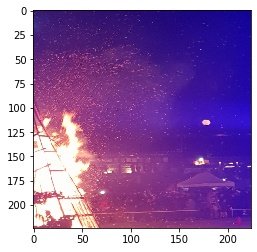

tf.Tensor(16, shape=(), dtype=int64)


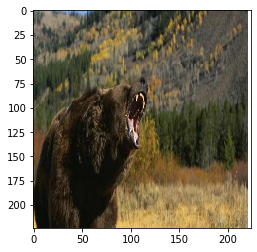

tf.Tensor(9, shape=(), dtype=int64)


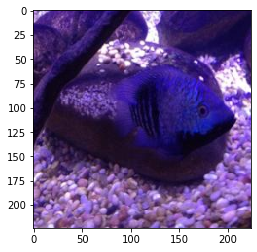

tf.Tensor(37, shape=(), dtype=int64)


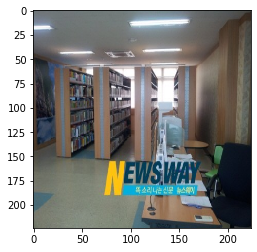

tf.Tensor(4, shape=(), dtype=int64)


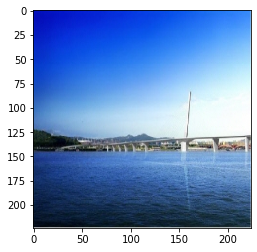

In [19]:
for data in parsed_trainset.take(5):
    print(data['label'])
    image_raw = tf.io.decode_raw(data['image'], tf.uint8)
    image_raw = tf.reshape(image_raw, [224, 224, 3])
    plt.imshow(image_raw)
    plt.show()

tf.Tensor(43, shape=(), dtype=int64)


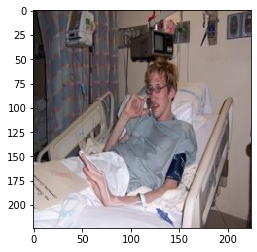

tf.Tensor(41, shape=(), dtype=int64)


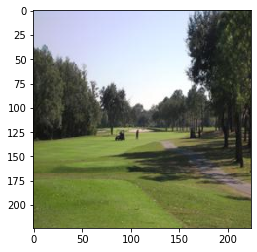

tf.Tensor(14, shape=(), dtype=int64)


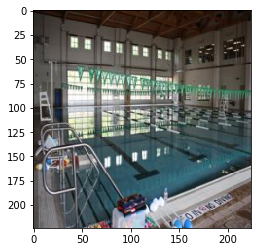

tf.Tensor(8, shape=(), dtype=int64)


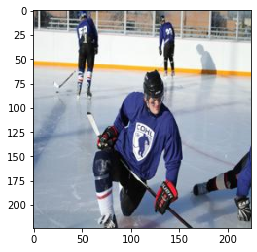

tf.Tensor(17, shape=(), dtype=int64)


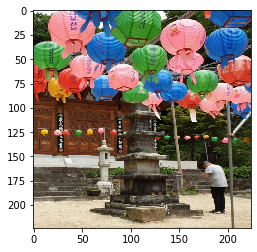

In [20]:
for data in parsed_validset.take(5):
    print(data['label'])
    image_raw = tf.io.decode_raw(data['image'], tf.uint8)
    image_raw = tf.reshape(image_raw, [224, 224, 3])
    plt.imshow(image_raw)
    plt.show()